In [33]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pathlib

In [27]:
data_dir = pathlib.Path('Dataset/Train')
batch_size = 32
img_height = 100
img_width = 100


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)


Found 25885 files belonging to 6 classes.
Using 20708 files for training.
Found 25885 files belonging to 6 classes.
Using 5177 files for validation.
['Apples', 'Cherries', 'Grapes', 'Pear', 'Peppers', 'Tomatoes']


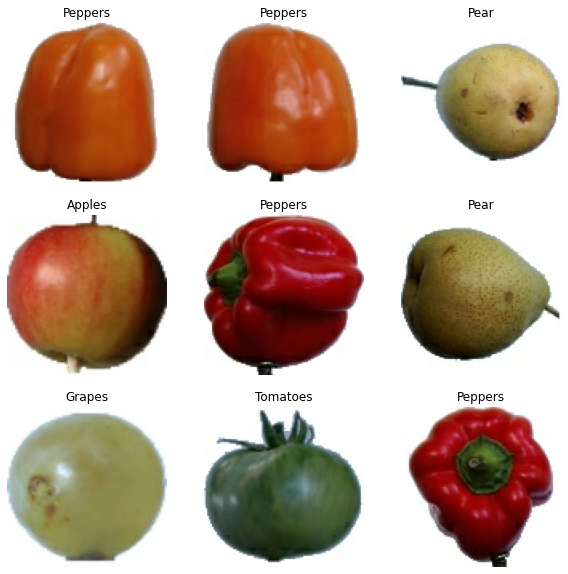

In [28]:
def plot_images():
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
plot_images()

In [29]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
### Normalization is added as layer to the model
# normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(train_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))
# plt.imshow(first_image.numpy().astype("uint8"))




(32, 100, 100, 3)
(32,)


In [36]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [35]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.